In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

import random
import json
import ast
import os
import cv2
import PIL

from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew
import math

import torch
import torchvision

import torch.nn as nn
from torch import optim
from torchvision import transforms

from PIL import Image
from tqdm import tqdm

C:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 0 1 2 -> 5 7 8

In [2]:
with open(r"C:\Users\Anton\Downloads\TlkWaterMeters\5 digits", "r") as file:
    lines = file.readlines()
    digits5 = [line.strip("\n") for line in lines]
    
with open(r"C:\Users\Anton\Downloads\TlkWaterMeters\7 digits", "r") as file:
    lines = file.readlines()
    digits7 = [line.strip("\n") for line in lines]

In [3]:
deskewed_path = r"C:\Users\Anton\Downloads\TlkWaterMeters\deskewed"
train_578_path = r"C:\Users\Anton\Downloads\TlkWaterMeters\train_578"

for n, image in zip(range(1244), os.listdir(deskewed_path)):
    dir_img = os.path.join(deskewed_path, image)
    photo = cv2.imread(os.path.join(dir_img))
    
    num = 8
    if image in digits5:
        cv2.imwrite(os.path.join(train_578_path, image[:-4]+"_5.jpg"), photo)
        continue
        
    if image in digits7:
        cv2.imwrite(os.path.join(train_578_path, image[:-4]+"_7.jpg"), photo)
        continue
        
    if n <= 400:
        parts = 5
    elif n <= 800:
        parts = 7
    else:
        cv2.imwrite(os.path.join(train_578_path, image[:-4]+"_8.jpg"), photo)
        continue
    
    chars = np.array_split(photo, num, axis=1)
    chars = chars[-parts:]
    chars = np.hstack(tuple(chars))
    
    cv2.imwrite(os.path.join(train_578_path, image[:-4]+"_"+str(parts)+".jpg"), chars)

In [4]:
images_data = []
labels_data = []
dirname = r"C:\Users\Anton\Downloads\TlkWaterMeters\train_578"
labels = {5: 0, 7: 1, 8: 2}

for image in os.listdir(dirname):
    dir_img = os.path.join(dirname, image)
    
    img = cv2.imread(os.path.join(dir_img))
    img = cv2.resize(img, (28, 28))
    images_data.append(img)
    
    label = int(dir_img[-5])
    labels_data.append(labels[label])

images_data = np.array(images_data, dtype=np.uint8)
labels_data = np.array(labels_data, dtype=np.uint8)

In [5]:
class Dataset(torch.utils.data.Dataset):   
    def __init__(self, images_data, labels_data):
        
        self.transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Grayscale(),
                transforms.RandomVerticalFlip(0.5), 
                transforms.ToTensor()
            ]
        )
        
        self.images_data = images_data
        self.y = torch.tensor(labels_data)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        img = self.transform(self.images_data[index])
        target = self.y[index]
        
        return img, target

In [6]:
img_train, img_test, target_train, target_test = train_test_split(images_data, labels_data, test_size=0.2, 
                                                                  random_state=42, shuffle=True)

In [7]:
img_train, img_val, target_train, target_val = train_test_split(img_train, target_train, test_size=0.1, 
                                                                random_state=42, shuffle=True)

In [8]:
train_dataset = Dataset(img_train, target_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = Dataset(img_val, target_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)

test_dataset = Dataset(img_test, target_test)
test_len = test_dataset.__len__()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_len, shuffle=False)

In [9]:
np.random.seed(42)
torch.manual_seed(42)

In [10]:
class CNN(nn.Module):
    def __init__(self, output_size=100, dropout=0.5):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.Conv2d(32, 96, kernel_size=4, stride=1, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                 )
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.fc = nn.Sequential(nn.Linear(128*6*6, 2048),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=dropout),
                                nn.Linear(2048, 1024),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=dropout),
                                nn.Linear(1024, output_size),
                                nn.LogSoftmax(dim=1)
                               )
        return
    
    def forward(self, x):
        x = self.conv(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [11]:
def validation(model, loader, criterion, device="cpu"):
    model.eval()
    loss = 0
    acc = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            output = model.forward(images)
#             print(output)
            loss += criterion(output,labels).item()
            
            probs = torch.exp(output)
            equality = (labels.data == probs.max(dim=1)[1])
            acc += equality.type(torch.FloatTensor).mean()
    res_loss = loss/len(loader)
    res_acc = (acc.item())/len(loader)
    return res_loss, res_acc

In [12]:
def train_model(model, trainloader, validloader, criterion, optimizer,
                scheduler, epochs=10, print_every=1, device="cpu"):
    model.to(device)
    best_acc = 0
    best_epoch = 0
    
    for e in range(epochs):
        model.train()        
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        model.eval()
        train_loss, train_accuracy = validation(model, trainloader, criterion, device)
        valid_loss, valid_accuracy = validation(model, validloader, criterion, device)
        
        if valid_accuracy > best_acc:
            best_acc = valid_accuracy
            best_epoch = e
            torch.save(model.state_dict(), "best-state-578.pt")
            
        if e % print_every == 0:
            to_print = "Epoch: "+str(e+1)+" of "+str(epochs)
            to_print += ".. Train Loss: {:.4f}".format(train_loss)
            to_print += ".. Valid Loss: {:.4f}".format(valid_loss)
            to_print += ".. Valid Accuracy: {:.3f}".format(valid_accuracy)
            print(to_print)
    
    model.load_state_dict(torch.load("best-state-578.pt"))
    to_print = "\nTraining completed. Best state dict is loaded.\n"
    to_print += "Best Valid Acc is: {:.4f} after {} epochs".format(best_acc,best_epoch+1)
    print(to_print)
    return

In [13]:
def prediction(model, loader, device="cpu"):
    model.to(device)
    model.eval()
    preds_all = torch.LongTensor()
    
    with torch.no_grad():
        for images, label in loader:
            images = images.to(device)
            
            output = model.forward(images)            
            probs = torch.exp(output)
            pred = probs.to('cpu').max(dim=1)[1]
            preds_all = torch.cat((preds_all, pred), dim=0)
    return preds_all

In [14]:
from torchsummary import summary

In [17]:
model_recognizer = CNN(output_size=3, dropout=0.5)
print(model_recognizer)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 96, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avg_pool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc): Sequential(
    (0): Linear(in_features=4608, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace

In [53]:
max_learning_rate = 0.001
n_epochs = 30
train_batch_size = 32
valid_batch_size = 16
steps_per_epoch = math.ceil(len(train_dataset)/32)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_recognizer.parameters(), lr=max_learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr = max_learning_rate,
                                          epochs = n_epochs,
                                          steps_per_epoch = steps_per_epoch,
                                          pct_start = 0.2,
                                          anneal_strategy = "cos")

In [54]:
train_model(model = model_recognizer, trainloader = train_loader,
            validloader = val_loader, criterion = criterion,
            optimizer = optimizer, scheduler = scheduler,
            epochs = n_epochs, print_every=1, device = "cpu")

Epoch: 1 of 30.. Train Loss: 1.0980.. Valid Loss: 1.0980.. Valid Accuracy: 0.375
Epoch: 2 of 30.. Train Loss: 1.0972.. Valid Loss: 1.1015.. Valid Accuracy: 0.295
Epoch: 3 of 30.. Train Loss: 1.0990.. Valid Loss: 1.0975.. Valid Accuracy: 0.304
Epoch: 4 of 30.. Train Loss: 1.0987.. Valid Loss: 1.0980.. Valid Accuracy: 0.321
Epoch: 5 of 30.. Train Loss: 1.0981.. Valid Loss: 1.1004.. Valid Accuracy: 0.268
Epoch: 6 of 30.. Train Loss: 1.1147.. Valid Loss: 1.1080.. Valid Accuracy: 0.375
Epoch: 7 of 30.. Train Loss: 0.9101.. Valid Loss: 1.0175.. Valid Accuracy: 0.420
Epoch: 8 of 30.. Train Loss: 0.8760.. Valid Loss: 0.9234.. Valid Accuracy: 0.518
Epoch: 9 of 30.. Train Loss: 0.7768.. Valid Loss: 0.8447.. Valid Accuracy: 0.509
Epoch: 10 of 30.. Train Loss: 0.7126.. Valid Loss: 0.7701.. Valid Accuracy: 0.580
Epoch: 11 of 30.. Train Loss: 0.6284.. Valid Loss: 0.8821.. Valid Accuracy: 0.571
Epoch: 12 of 30.. Train Loss: 0.5143.. Valid Loss: 0.8005.. Valid Accuracy: 0.679
Epoch: 13 of 30.. Train L

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [20]:
model_recognizer.load_state_dict(torch.load('best-state-578.pt'))
model_recognizer.eval()

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 96, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avg_pool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc): Sequential(
    (0): Linear(in_features=4608, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace

In [21]:
y_pred = prediction(model_recognizer, test_loader)
y_true = target_test

In [24]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(3)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[5, 7, 8])

In [35]:
import matplotlib.pyplot as plt

In [38]:
font = {
    'weight': 'normal',
    'size'   : 22}
plt.rc('font', **font)

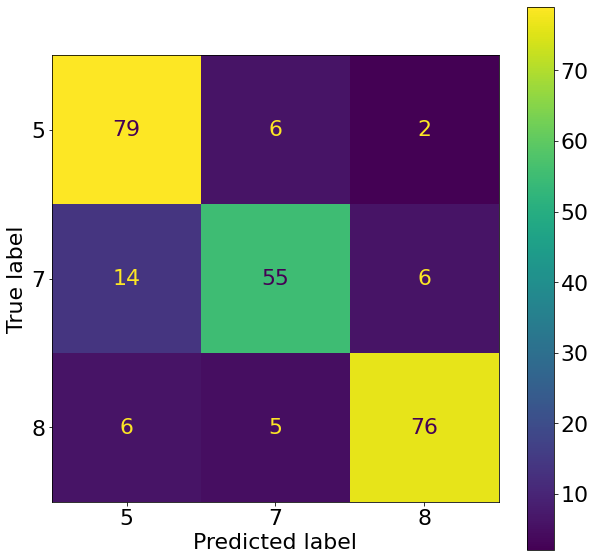

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
accuracy_score(y_true, y_pred)

0.8433734939759037